# Import the Libraries

In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score

import plotly.express as px

import joblib

# Load the dataset

In [51]:
data = pd.read_csv(r'D:\Case Study 2\Country-data.csv')

In [52]:
data.head(3)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460


# Let's explore the data 

In [53]:
data.shape

(167, 10)

In [54]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


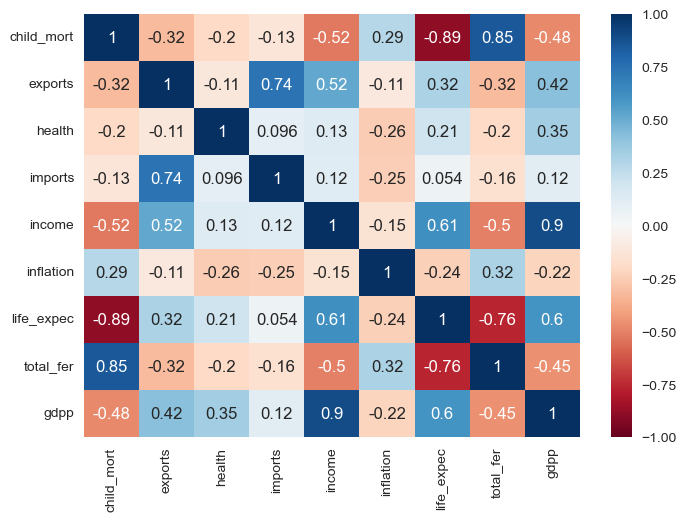

In [55]:
# Correlation Heatmap

sns.heatmap(data.corr(numeric_only= True), annot = True, vmin = -1, cmap = 'RdBu')
plt.show()

# Visualize the data

In [56]:
# Before we begin visualization let's convert country to index (as it's a redundant column)

data.set_index('country', inplace = True)
data.head(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090


# Univariate Analysis

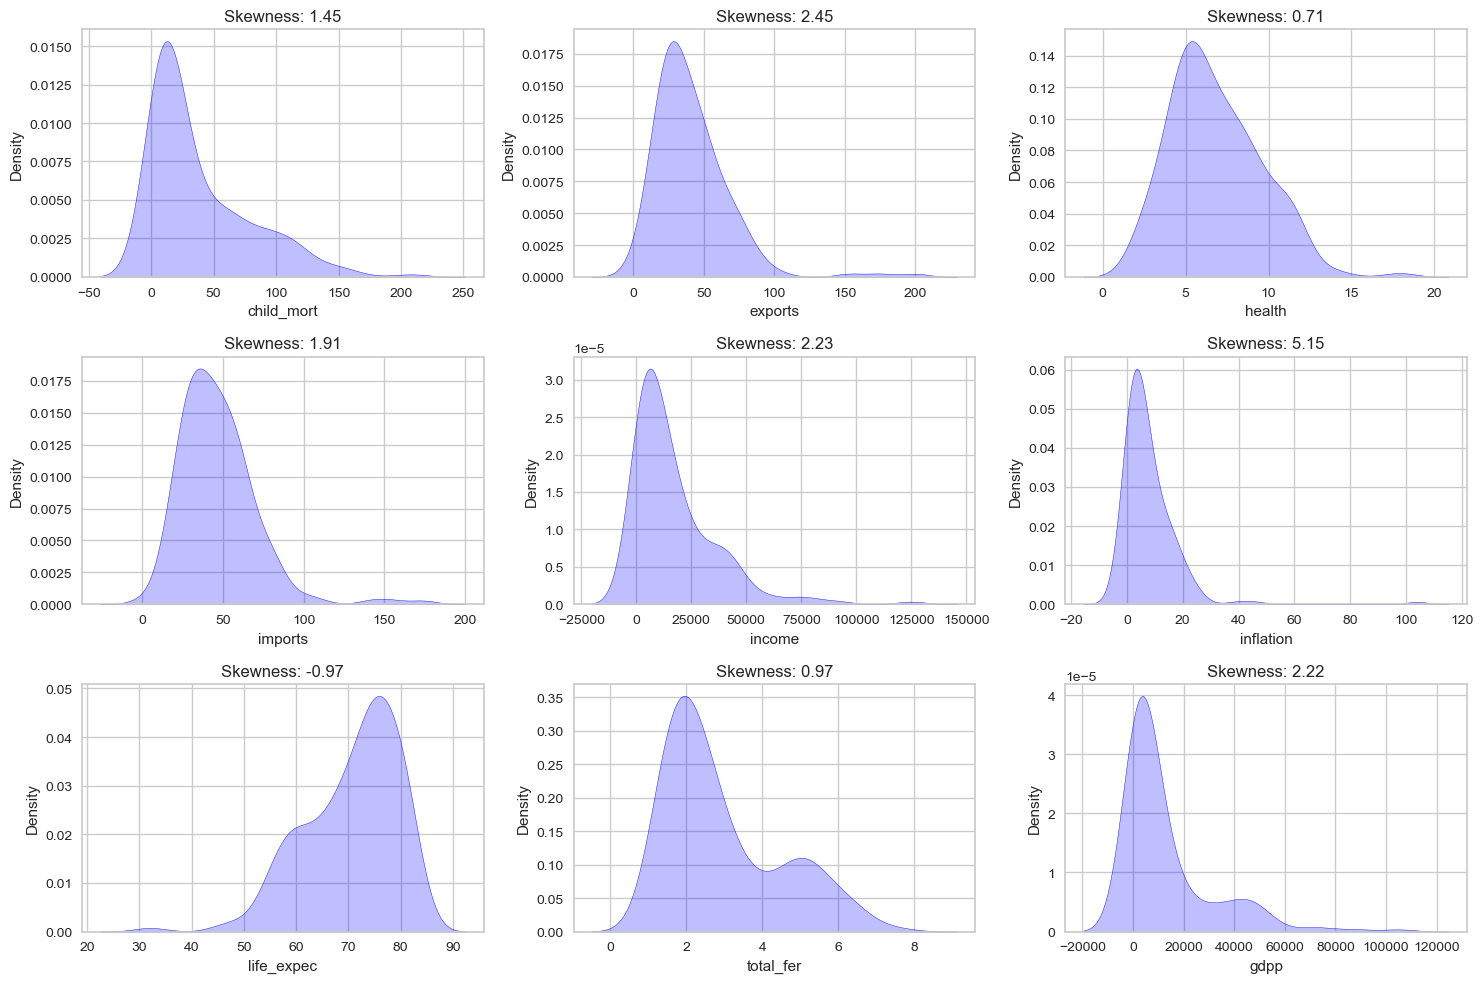

In [57]:
# KDE Plot to check the distribution

t = 1
plt.figure(figsize = (15,10))

for i in data.columns:
  plt.subplot(3,3,t)
  sns.kdeplot(data = data, x = i, fill = True, color = 'blue')
  plt.title(f'Skewness: {round(data[i].skew(),2)}')
  t+=1
plt.tight_layout()
plt.show()

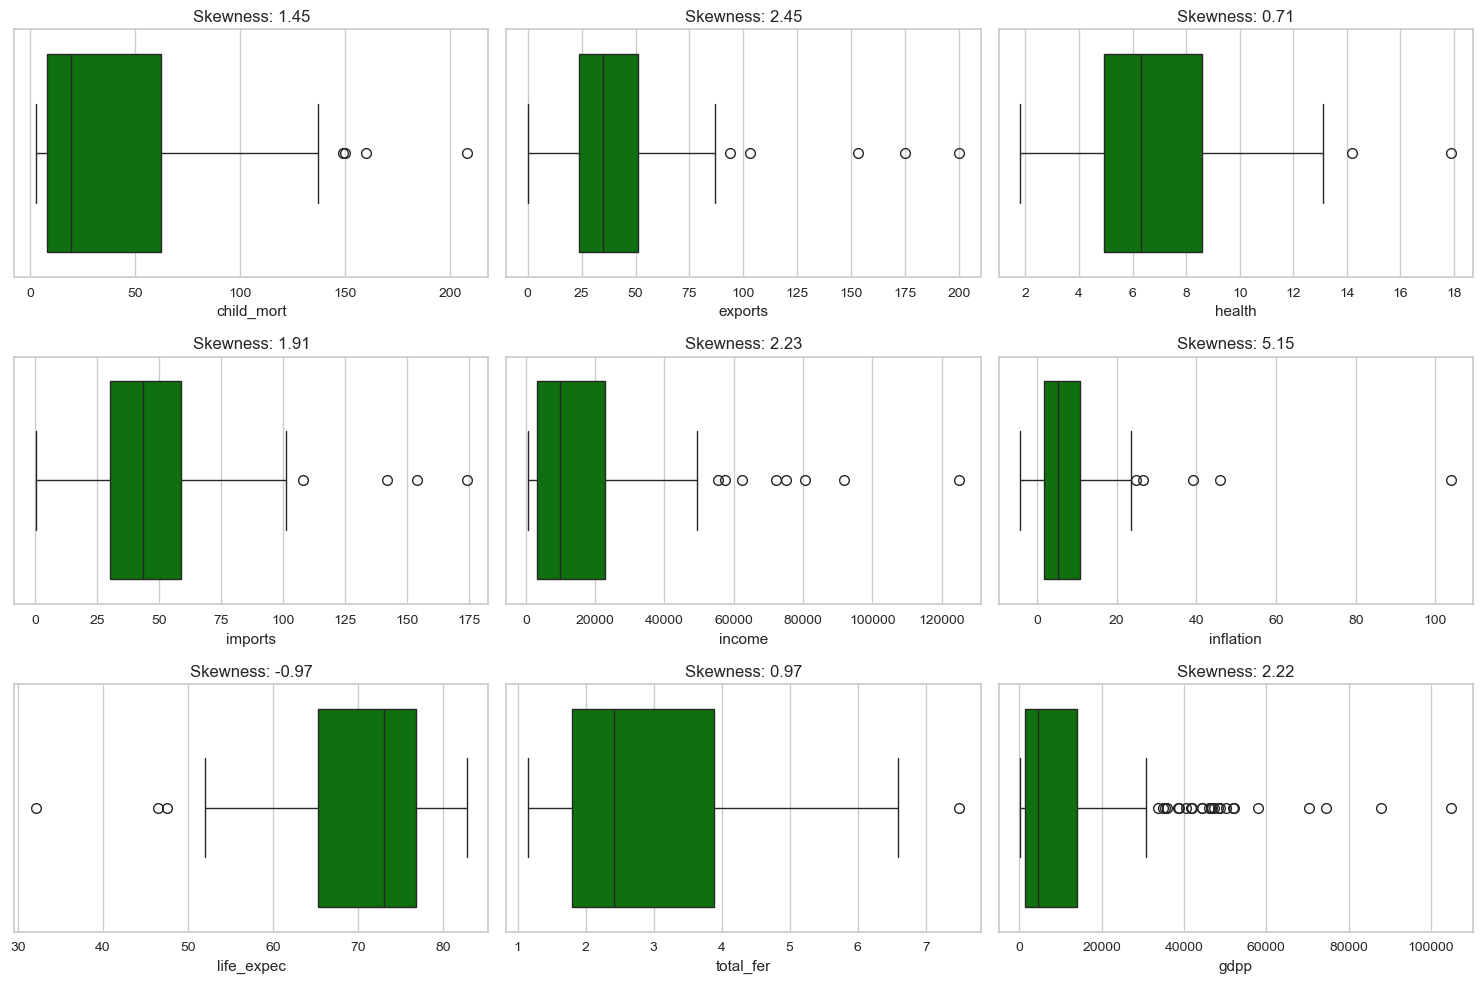

In [58]:
# Boxplot to visualise the outliers

t = 1
plt.figure(figsize = (15,10))

for i in data.columns:
  plt.subplot(3,3,t)
  sns.boxplot(data = data, x = i, color = 'green')
  plt.title(f'Skewness: {round(data[i].skew(),2)}')
  t+=1
plt.tight_layout()
plt.show()

# Multivariate Analysis

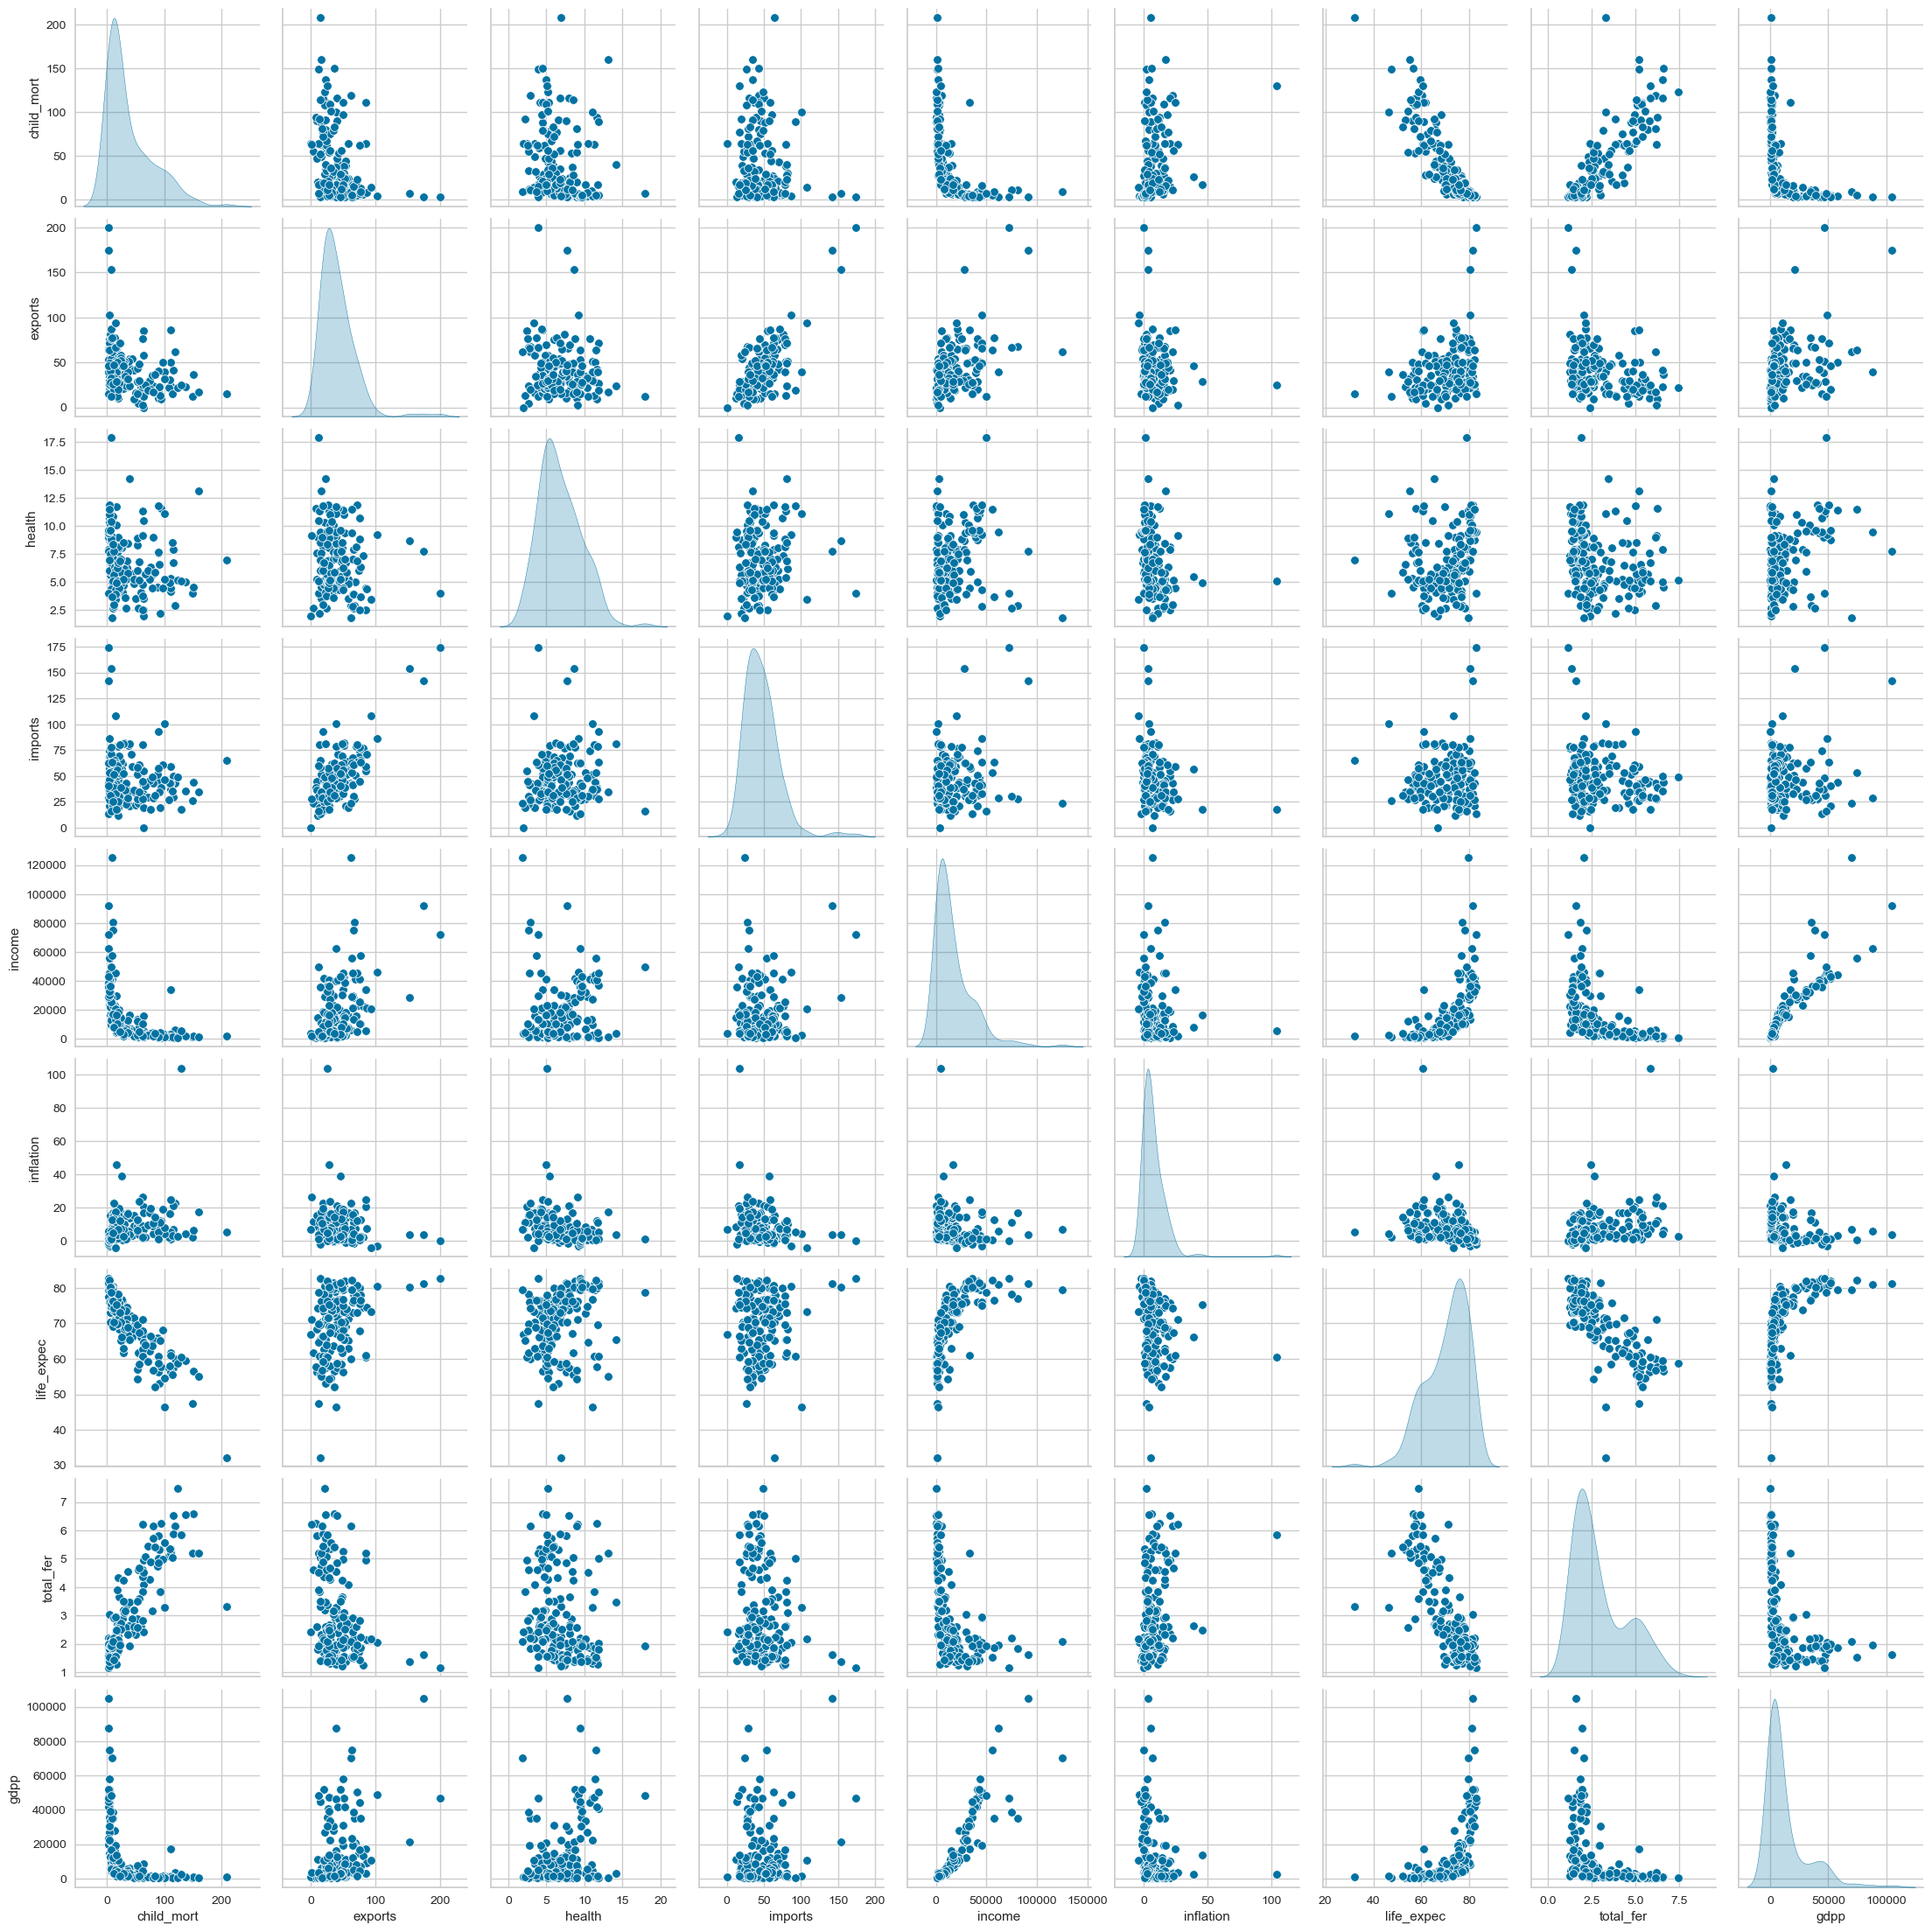

In [59]:
# Pairplot

sns.pairplot(data, diag_kind = 'kde')
plt.show()

# Preprocessing

In [60]:
# Check for missing values

data.isnull().sum().sum()

0

Inference: Data has no missing values

In [61]:
# Let's treat the extreme outliers 
# We will go with Capping using IQR Method
# In order to cap only the extreme ones, let's keep whisker length = 2.5

for i in data.columns:
  q1, q3 = np.quantile(data[i], [0.25, 0.75])
  iqr = q3 - q1
  ul, ll = q3 + 2.5 * iqr, q1 - 2.5 * iqr
  data[i] = data[i].apply(lambda x: ul if x > ul else ll if x < ll else x)

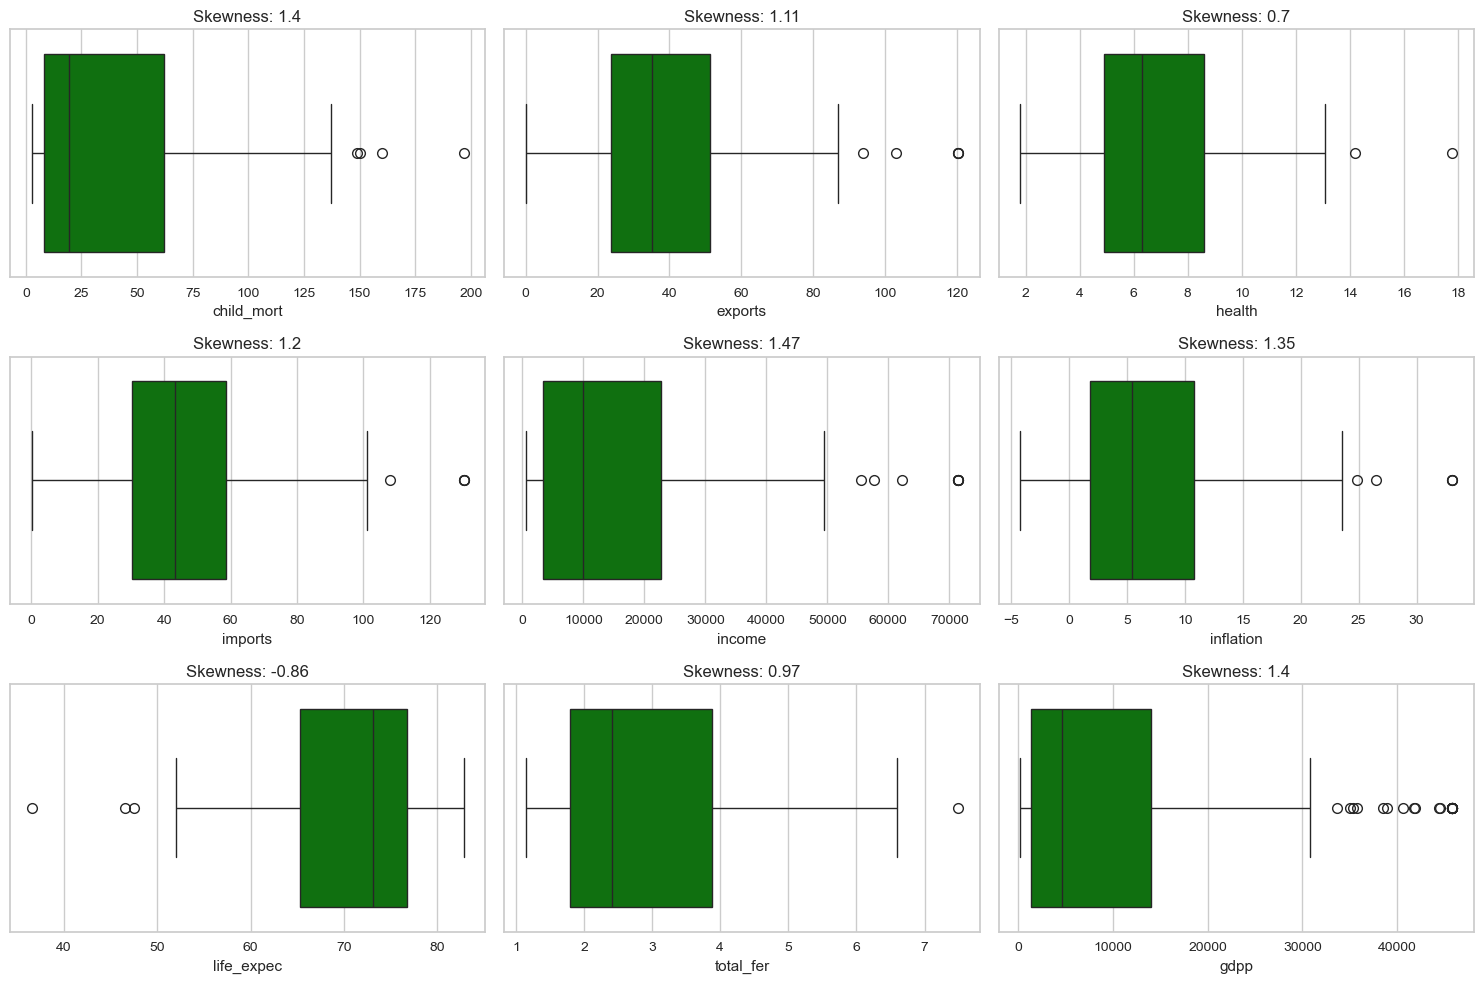

In [ ]:
# Let's check if outliers have been treated 

t = 1
plt.figure(figsize = (15,10))

for i in data.columns:
  plt.subplot(3,3,t)
  sns.boxplot(data = data, x = i, color = 'green')
  plt.title(f'Skewness: {round(data[i].skew(),2)}')
  t+=1
plt.tight_layout()
plt.show()

In [63]:
# Let's apply PCA on the data before we proceed with clustering. Just to have better visualization and better clustering.
# In PCA, we need to pass Standardized Data. So, let's import the functions from libraries.

# Let's create an instance of Scaling
scaler = StandardScaler()

# Also, let's create an instance for PCA
pca = PCA(n_components= 5, random_state= 2)

# Let's create a pipeline for the above two processes
pipeline = Pipeline([('Scale', scaler), 
                    ('PCA', pca)])

In [64]:
pipeline.fit(data)

Pipeline(steps=[('Scale', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=2))])

In [65]:
pca.explained_variance_ratio_.cumsum()

# At n_components = 5, we are able to explain ~95% variance, which is good enough. 
# So, 9-Dimension data can be reduced to 5-Dimensions

array([0.4758564 , 0.64300208, 0.77845398, 0.88018006, 0.94647697])

In [66]:
final_data = pipeline.transform(data)

In [67]:
# .transform returns the array. Let's convert it into dataframe

final_data = pd.DataFrame(final_data, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
                          index= data.index)
final_data.head(3)

,PC1,PC2,PC3,PC4,PC5
country,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119


## K-Means Clustering

In [68]:
# Identify the value of k 

# KElbow Visualizer
kelbow = KElbowVisualizer(estimator= KMeans(random_state= 2), k = 10)

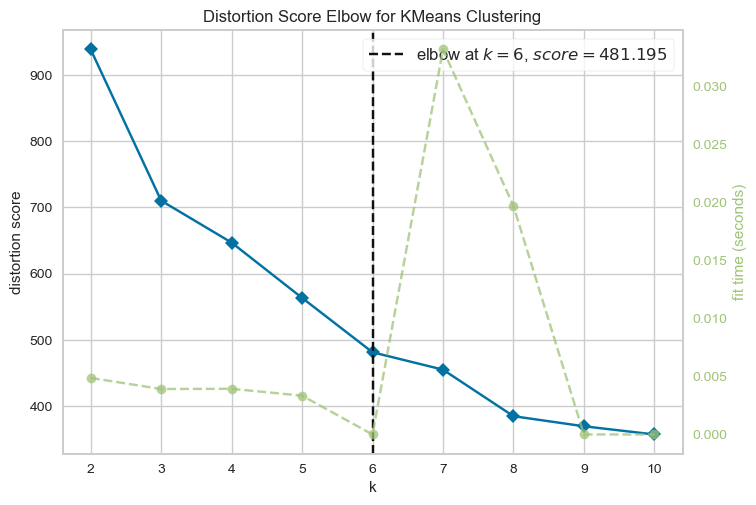

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [69]:
kelbow.fit(final_data)
kelbow.show()

Inference: Although the above plot marks the elbow at k = 6, we can see the significant drop in distortion score from k = 2 to k = 3. As we increase the number of clusters, it might become overfitted. Let's explore Silhouette Visualizer to identify the correct or more generalised value of k. 

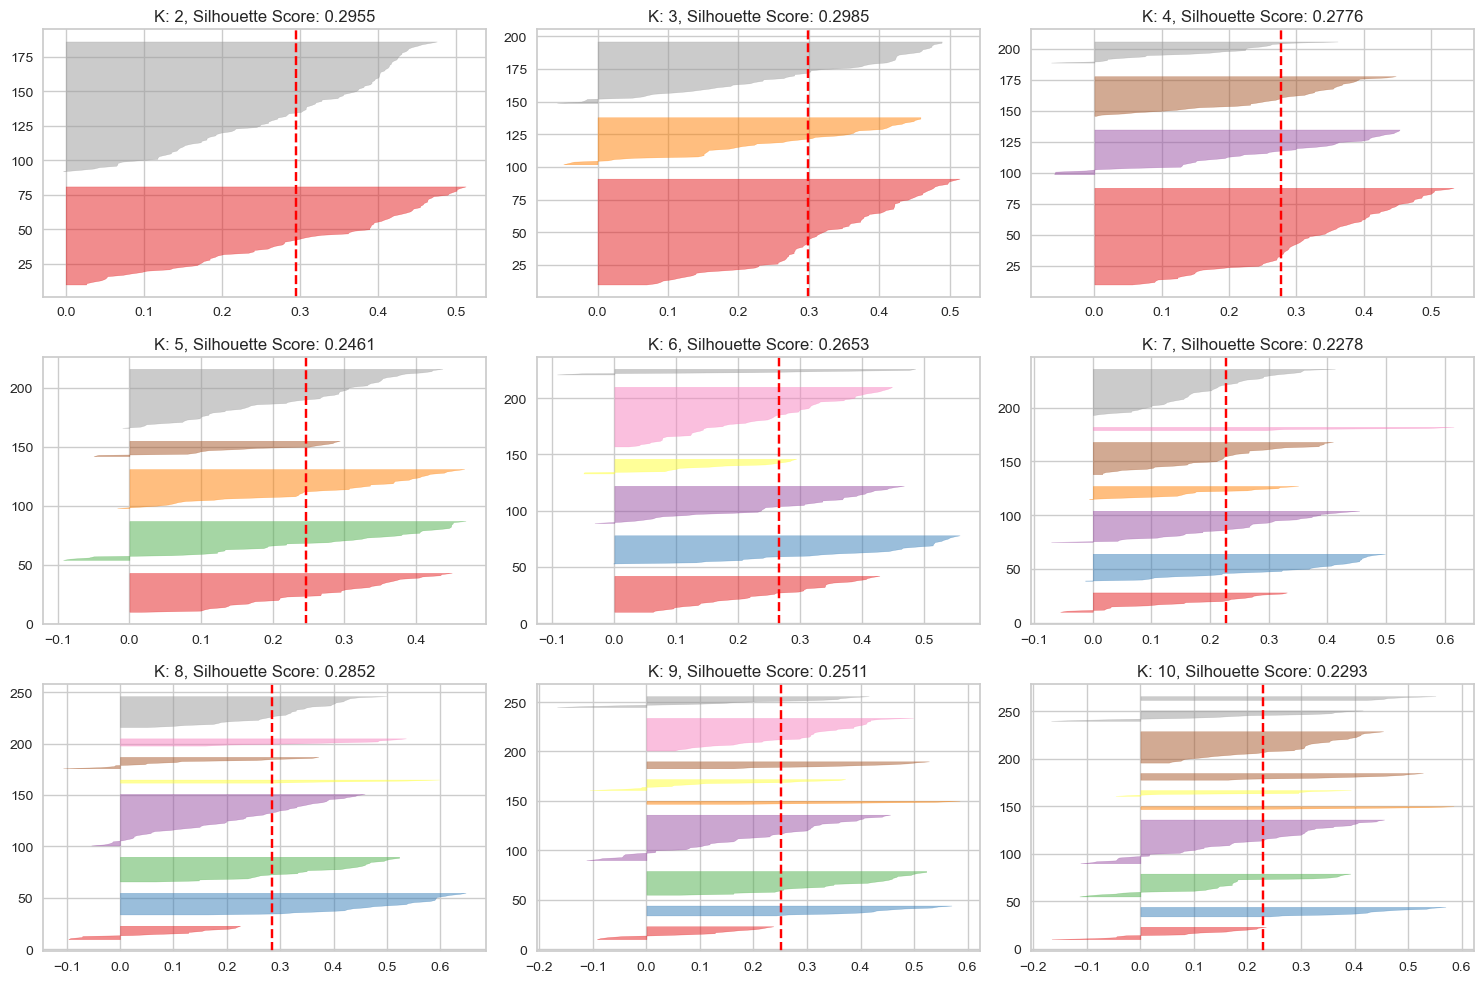

In [72]:
# Silhouette Visualizer

t = 1
plt.figure(figsize= (15, 10))
for i in range(2,11):
    plt.subplot(3,3,t)   
    model = KMeans(n_clusters = i, random_state = 2)
    sil_viz = SilhouetteVisualizer(model)
    sil_viz.fit(final_data)
    plt.title(f'K: {i}, Silhouette Score: {round(sil_viz.silhouette_score_,4)}')
    t +=1
plt.tight_layout()
plt.show()

Inference: After analyzing Elbow Plot and Silhouette Visualizer, let's go with k = 3. Although there are few data points that have been misclassified, but we see no drop in Silhouette Score and there is good enough data in every cluster. Also from K-Elbow Plot, significant drop in WCSS (Distortion score) was observed from k = 2 to k = 3.

In [73]:
final_kmeans = KMeans(n_clusters= 3, random_state= 2)

In [74]:
labels = final_kmeans.fit_predict(final_data)

In [75]:
# Let's check the Silhouette Score 

print('Silhouette Score:', silhouette_score(final_data, labels))

Silhouette Score: 0.2984578234829661


In [76]:
# Let's put these labels on PCA data

final_data['Labels'] = labels
final_data.head(3)

,PC1,PC2,PC3,PC4,PC5,Labels
country,,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800,2
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623,0
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119,0


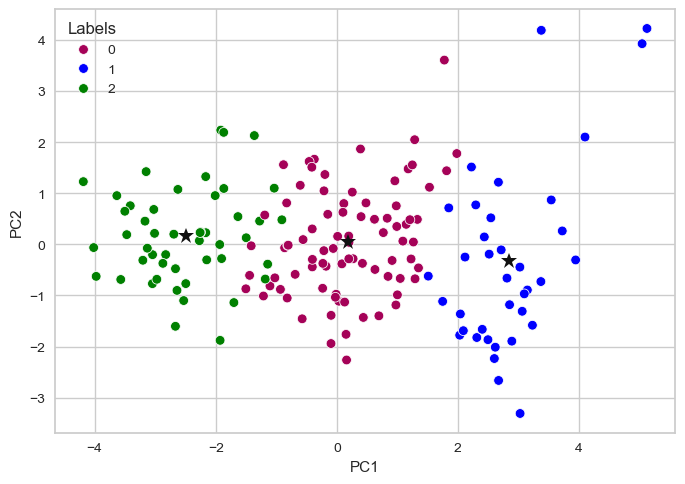

In [83]:
# Let's visualize the clusters
# In order to get the best visualization let's choose PC1 and PC2 as they have maximum variance.

centroids = final_kmeans.cluster_centers_
centroids

sns.scatterplot(data= final_data, x = 'PC1', y = 'PC2', palette= ['m', 'blue', 'green'], hue= 'Labels')
for i in range(3):
    plt.plot(centroids[i][0], centroids[i][1], marker = '*', ms = 12, color = 'k')
plt.show()

## Business Interpretation

In [84]:
# To have business understanding, let's put the labels on the original dataset

data['Label'] = labels
data.head(3)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Label
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,2
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,0
Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,0


In [85]:
data.groupby('Label').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Label,,,,,,,,,
0,21.508537,40.797317,6.231951,48.097561,12281.097561,7.474744,72.875610,2.311707,6291.146341
1,5.237838,53.575000,8.780270,49.129054,42690.878378,2.588432,79.956757,1.755676,36905.405405
2,92.131771,28.546229,6.296458,41.443040,3937.770833,10.438854,59.438542,4.953958,1902.916667


After studying the above data, we can conclude that countries that have been assigned in cluster 2 can be called Underdeveloped, while cluster 1 are Developed. Countries belonging to cluster 0 are doing average in most of the factors but struggling in some economic factors like GDPP, Income and expenditure on health. Hence, they can be called Developing. 

In [86]:
# Let's rename these labels

data['Label'] = data['Label'].map({0: 'Developing',
                                   1: 'Developed',
                                   2: 'Underdeveloped'})

In [88]:
# Developed Countries

data[data['Label'] == 'Developed'].index

Index(['Australia', 'Austria', 'Bahamas', 'Bahrain', 'Belgium', 'Brunei',
       'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Finland', 'France',
       'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kuwait', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway',
       'Portugal', 'Qatar', 'Singapore', 'Slovak Republic', 'Slovenia',
       'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates',
       'United Kingdom', 'United States'],
      dtype='object', name='country')

In [90]:
# Developing Countries

data[data['Label'] == 'Developing'].index

Index(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia',
       'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Fiji', 'Georgia', 'Grenada', 'Guatemala', 'Guyana', 'Hungary', 'India',
       'Indonesia', 'Iran', 'Jamaica', 'Jordan', 'Kazakhstan',
       'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya', 'Lithuania',
       'Macedonia, FYR', 'Malaysia', 'Maldives', 'Mauritius',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco',
       'Nepal', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland',
       'Romania', 'Russia', 'Samoa', 'Saudi Arabia', 'Serbia', 'Seychelles',
       'Solomon Islands', 'Sri Lanka', 'St. Vincent and the Grenadines',
       'Suriname', 'Tajikistan', '

In [91]:
# Underdeveloped Countries

data[data['Label'] == 'Underdeveloped'].index

Index(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea',
       'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Myanmar',
       'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal',
       'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste',
       'Togo', 'Uganda', 'Yemen', 'Zambia'],
      dtype='object', name='country')

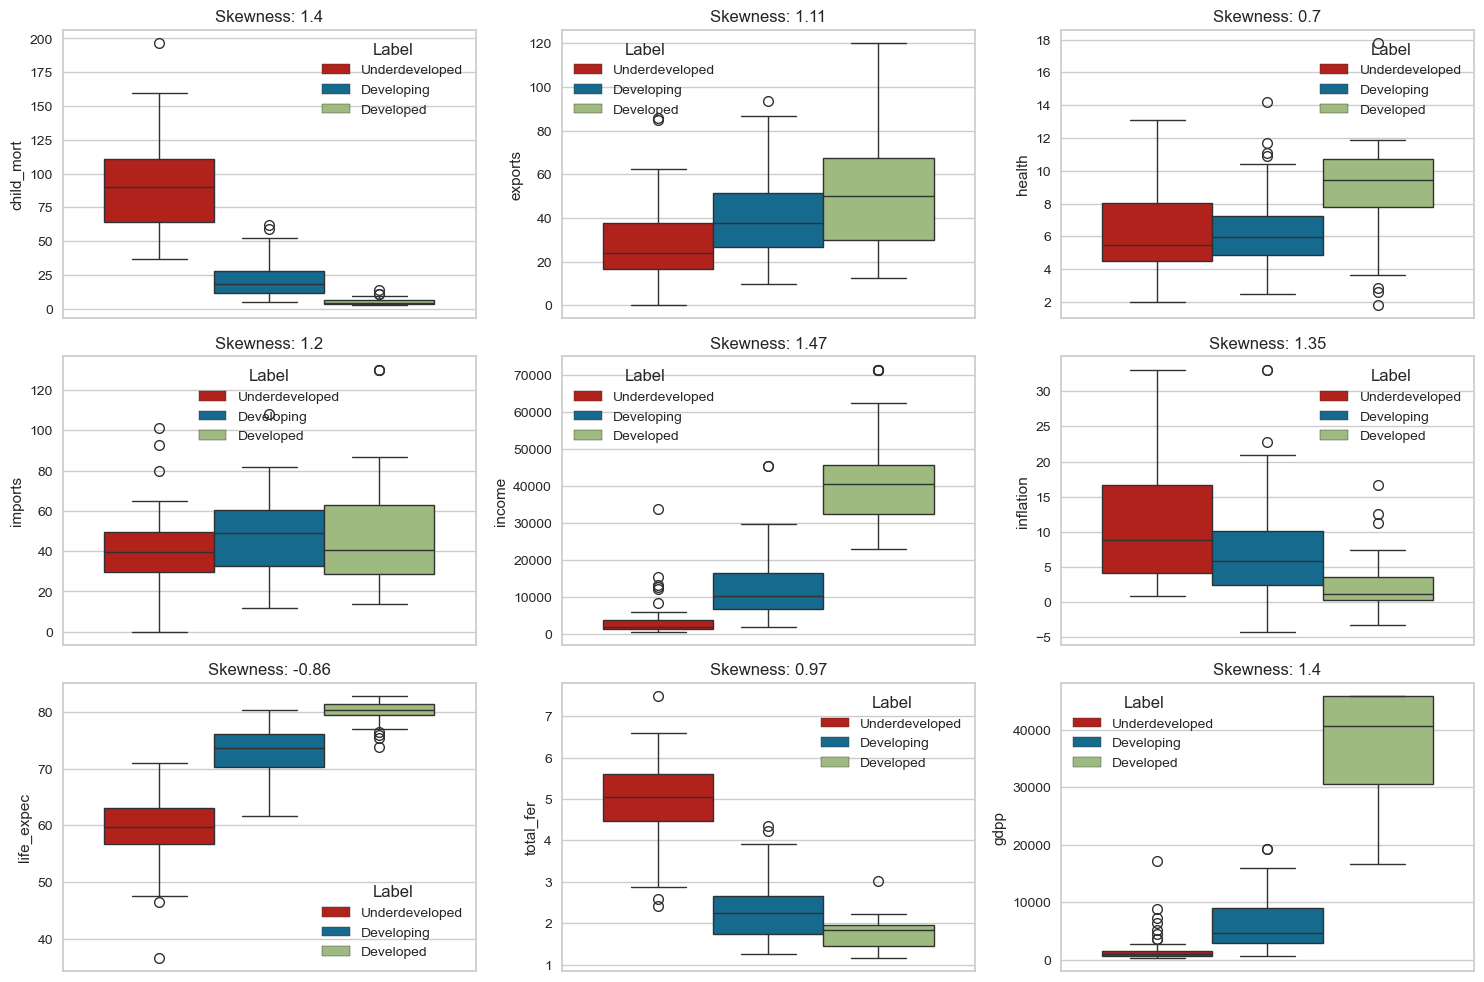

In [ ]:
t = 1
plt.figure(figsize = (15,10))

for i in data.columns:
  if i != 'Label':
    plt.subplot(3,3,t)
    sns.boxplot(data = data, y = i, hue= 'Label', palette= ['r', 'b', 'g'])
    plt.title(f'Skewness: {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [94]:
# World Map

px.choropleth(data_frame= data, locationmode= 'country names', 
              locations= data.index, color = 'Label', 
              color_discrete_map= {'Underdeveloped': 'red', 'Developing': 'blue', 'Developed': 'green'})

# Deployment

In [102]:
input_data = data.iloc[0,:-1].values
input_data

array([90.2, 10.0, 7.58, 44.9, 1610.0, 9.44, 56.2, 5.82, 553.0],
      dtype=object)

In [103]:
final_input_data = pipeline.transform([input_data])
final_input_data

array([[-3.04363665, -0.20115529,  0.95132235,  0.79344472, -0.00680001]])

In [107]:
final_kmeans.predict(final_input_data)[0]

2

In [110]:
# Let's create a joblib file of pipeline 

with open('pipeline.joblib', 'wb') as file:
    joblib.dump(pipeline, file)

In [111]:
# Let's create a joblib file of model 

with open('model.joblib', 'wb') as file:
    joblib.dump(final_kmeans, file)